# Домашнее задание №1 - Метод К-ближайших соседей (K-neariest neighbors)

Сегодня мы с вами реализуем наш первый алгоритм машинного обучения, метод К-ближайших соседей. Мы попытаемся решить с помощью него задачи:
- бинарной классификации (то есть, только двум классам)
- многоклассовой классификации (то есть, нескольким классам)
- регрессии (когда зависимая переменная - натуральное число)

Так как методу необходим гиперпараметр (hyperparameter) - количество соседей, то нам нужно научиться подбирать этот параметр. Мы постараемся научиться пользовать numpy для векторизованных вычислений, а также посмотрим на несколько метрик, которые используются в задачах классификации и регрессии.

Перед выполнением задания:
- установите все необходимые библиотеки, запустив `pip install -r requirements.txt`

Если вы раньше не работали с numpy или позабыли его, то можно вспомнить здесь:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd


from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from knn import KNNClassifier
from metrics import binary_classification_metrics, multiclass_accuracy

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

## Задание 1. KNN на датасете Fashion-MNIST (10 баллов)

В этом задании вам предстоит поработать с картинками одежды, среди которых можно выделить 10 классов. Данные уже загружены за вас: в переменной X лежат 70000 картинок размером 28 на 28 пикселей, вытянутые в вектор размерностью 784 (28 * 28). Так как данных довольно много, а наш KNN будет весьма медленный, то возьмем случайно 1000 наблюдений (в реальности в зависимости от вашей реализации можно будет взять больше, но если будет не зватать ОЗУ, то берите меньше).

In [3]:
X, y = fetch_openml(name="Fashion-MNIST", return_X_y=True, as_frame=False)

In [4]:
idx_to_stay = np.random.choice(np.arange(X.shape[0]), replace=False, size=1000)
X = X[idx_to_stay]
y = y[idx_to_stay]

Давайте посмотрим на какое-нибудь изображение из наших данных:

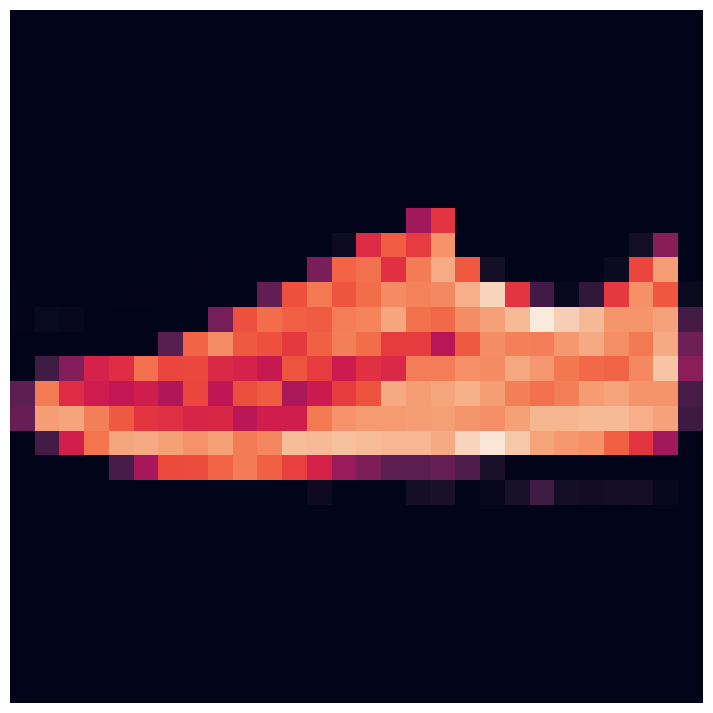

In [5]:
# возьмем случайную картинку и сделаем reshape
# 28, 28, 1 = H, W, C (число каналов, в данном случае 1)
image = X[np.random.choice(np.arange(X.shape[0]))].reshape(28, 28, 1)
plt.imshow(image)
plt.axis("off");

### 1.1. Посмотрим на все классы (0.5 баллов)

Возьмите по одной картинке каждого класса и изобразите их (например, сделайте subplots 5 на 2).

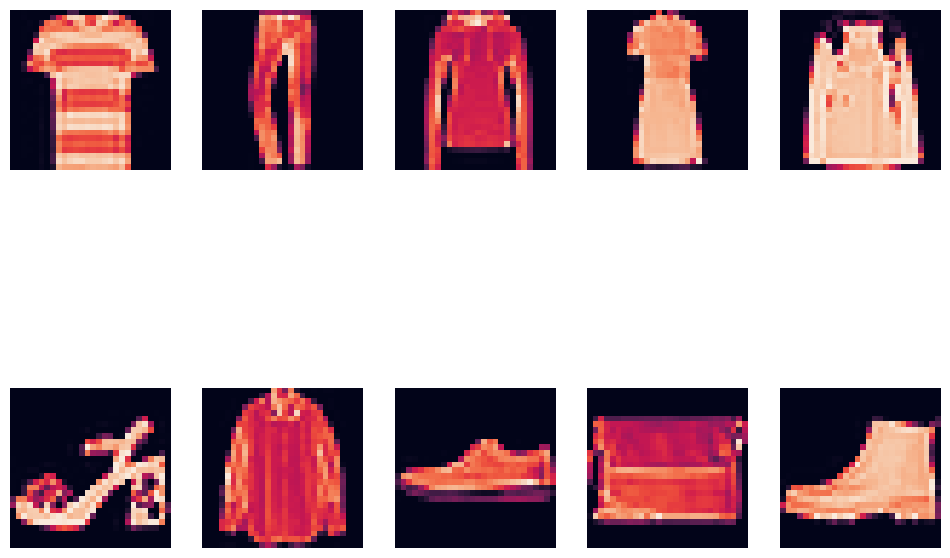

In [6]:
selected_idxs = []
for class_value in range(10):
    selected_idxs.append(np.random.choice(np.where(y == str(class_value))[0], size=1)[0])

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[selected_idxs[i]].reshape(28, 28, 1))
    plt.axis("off")

### 1.2. Сделайте небольшой EDA (1 балл)

Посмотрите на баланс классов. В дальнейших домашках делайте EDA, когда считаете нужным, он нужен почти всегда, но оцениваться это уже не будет, если не будет указано иное. Делайте EDA, чтобы узнать что-то новое о данных!

In [12]:
X.shape

(1000, 784)

Class 0 size: 93
Class 1 size: 102
Class 2 size: 95
Class 3 size: 121
Class 4 size: 96
Class 5 size: 98
Class 6 size: 101
Class 7 size: 79
Class 8 size: 109
Class 9 size: 106




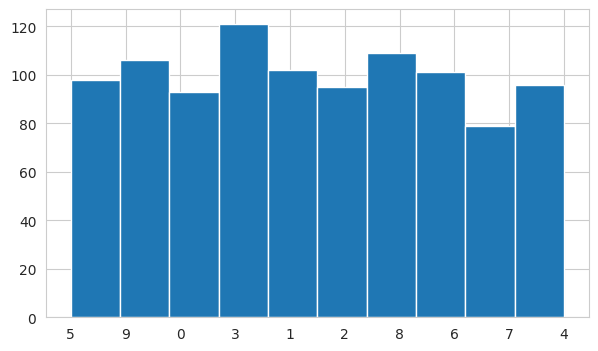

In [7]:
for class_value in range(10):
    print(f'Class {class_value} size: {len(np.where(y == str(class_value))[0])}')

print('\n')

plt.figure(figsize=(7, 4))
plt.hist(y)
plt.show()

### 1.3. Разделите данные на train и test (0.5 баллов)

Разделите данные на тренировочную и тестовую выборки, размеры тестовой выборки выберите сами. Здесь вам может помочь функция `train_test_split`

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3,
                                                    random_state=SEED)

### 1.4. KNN для бинарной классификации (6 баллов)

Давайте возьмем для задачи бинарной классификации только объекты с метками классов 0 и 1.

In [22]:
selected_idxs_train = np.where((y_train == '0') | (y_train == '1'))[0]

selected_idxs_test = np.where((y_test == '0') | (y_test == '1'))[0]

binary_train_X, binary_test_X, binary_train_y, binary_test_y = X_train[selected_idxs_train], X_test[selected_idxs_test], y_train[selected_idxs_train], y_test[selected_idxs_test]

И вот мы подготовили данные, но модели у нас пока что нет. В нескольких занятиях нашего курса вам придется самостоятельно реализовывать какие-то алгоритмы машинного обучения, а потом сравнивать их с готовыми библиотечными решениями. В остальных заданиях реализовывать алгоритмы будет не обязательно, но может быть полезно, поэтому часто это будут задания на дополнительные баллы, но главное не это, а понимание работы алгоритма после его реализации с нуля на простом numpy. Также это все потом можно оформить в виде репозитория ml_from_scratch и хвастаться перед друзьями.

In [23]:
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

### Настало время писать код!

В KNN нам нужно для каждого тестового примера найти расстояния до всех точек обучающей выборки. Допустим у нас 1000 примеров в train'е и 100 в test'е, тогда в итоге мы бы хотели получить матрицу попарных расстояний (например, размерностью 100 на 1000). Это можно сделать несколькими способами, и кому-то наверняка, в голову приходит идея с двумя вложенными циклами (надеюсь, что не больше:). Так можно делать, то можно и эффективнее. Вообще, в реальном KNN используется структура данных [k-d-tree](https://ru.wikipedia.org/wiki/K-d-%D0%B4%D0%B5%D1%80%D0%B5%D0%B2%D0%BE), которая позволяет производить поиск за log(N), а не за N, как будем делать мы (по сути это такое расширение бинарного поиска на многомерное пространство).

Вам нужно будет последовательно реализовать методы `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops` класса `KNN` в файле `knn.py`.

Эти функции строят массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате они должны построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

**Обратите внимание** Для простоты реализации мы будем использовать в качестве расстояния меру L1 (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)).

$d_{1}(\mathbf {p} ,\mathbf {q} )=\|\mathbf {p} -\mathbf {q} \|_{1}=\sum _{i=1}^{n}|p_{i}-q_{i}|$

В начале я буду иногда писать разные assert'ы, чтобы можно было проверить правильность реализации, в дальнейшем вам нужно будет их писать самим, если нужно будет проверять корректность каких-то вычислений.

In [24]:
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

In [25]:
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

In [26]:
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

Проверим скорость работы реализованных методов

In [27]:
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

40.9 ms ± 480 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
6.15 ms ± 133 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
25.6 ms ± 659 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Реализуем метод для предсказания меток класса

In [28]:
prediction = knn_classifier.predict(binary_test_X)

### Метрика

Теперь нужно реализовать несколько метрик для бинарной классификации. Не забудьте подумать о численной нестабильности (деление на 0).

In [29]:
binary_classification_metrics(prediction, binary_test_y)

(0.9714285714285714, 1.0, 0.9855072463768116, 0.9841269841269841)

Все ли хорошо с моделью? Можно проверить свою реализацию с функциями из библиотеки `sklearn`:

<img src="https://i.imgflip.com/406fu9.jpg" width="800" height="400">

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [31]:
my_metrics = (binary_classification_metrics(prediction, binary_test_y))

for sc_metrics, my_res in zip((precision_score, recall_score, f1_score), my_metrics[:3]):
    print(round(sc_metrics(binary_test_y, prediction, pos_label='1')) == round(my_res))

print(round(accuracy_score(prediction, binary_test_y)) == round(my_metrics[3]))

True
True
True
True


### Подбор оптимального k

Чтобы подрбрать оптимальное значение параметра k можно сделать следующее: задать область допустимых значений k, например, `[1, 3, 5, 10]`. Дальше для каждого k обучить модель на тренировочных данных, сделать предсказания на тестовых и посчитать какую-нибудь метрику (метрику выберите сами исходя из задачи, но постарайтесь обосновать выбор). В конце нужно посмотреть на зависимость метрики на train'е и test'е от k и выбрать подходящее значение.

Реализуйте функцию `choose_best_k` прямо в ноутбуке.

In [32]:
def find_best_k(X_train, y_train, X_test, y_test, params, metric):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    # precision, recall, f1, accuracy
    binary_metrics_idxs = {
        'precision': 0,
        'recall': 1,
        'f1': 2,
        'accuracy': 3
    }

    metrics_train_list = []
    metrics_test_list = []

    if metric in binary_metrics_idxs:
        classification_metrics = binary_classification_metrics
        metrics_idxs = binary_metrics_idxs[metric]
    else:
        classification_metrics = metric
        metrics_idxs = -1

    for k_to_check in params:
        knn_classifier = KNNClassifier(k=k_to_check)

        knn_classifier.fit(X_train, y_train)

        prediction_train = knn_classifier.predict(X_train)
        prediction_test = knn_classifier.predict(X_test)

        metrics_train = classification_metrics(prediction_train, y_train)
        metrics_test = classification_metrics(prediction_test, y_test)

        if metrics_idxs > 0:
            metrics_train = metrics_train[metrics_idxs]
            metrics_test = metrics_test[metrics_idxs]

        metrics_train_list.append(metrics_train)
        metrics_test_list.append(metrics_test)

    return metrics_train_list, metrics_test_list

In [33]:
# My function
params = [1, 2, 4, 5, 8, 10, 30]
train_metrics, test_metrics = find_best_k(binary_train_X, binary_train_y, binary_test_X, binary_test_y, params, 'accuracy')

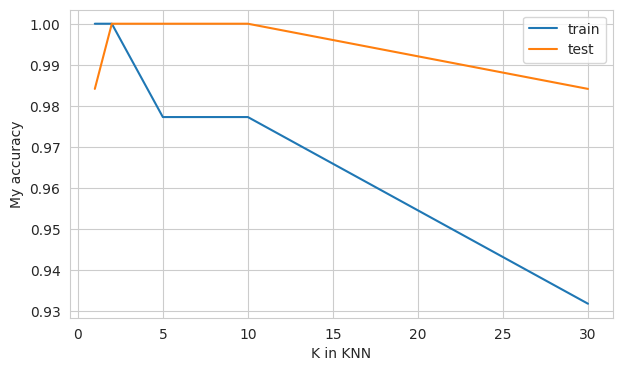

In [34]:
plt.figure(figsize=(7,4))
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("My accuracy");

In [36]:
# sklearn
params = [1, 2, 4, 5, 8, 10, 30]
train_metrics, test_metrics = find_best_k(binary_train_X, binary_train_y, binary_test_X, binary_test_y, params, accuracy_score)

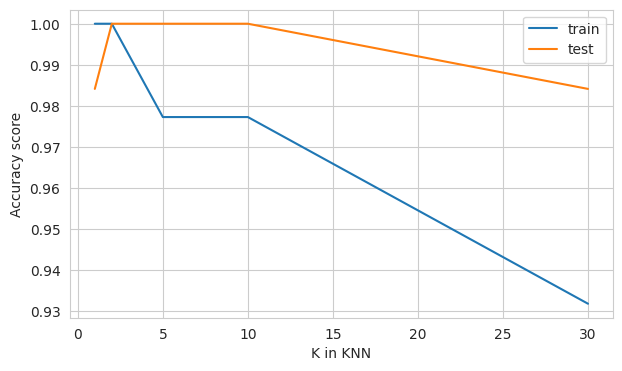

In [37]:
plt.figure(figsize=(7,4))
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("Accuracy score");

На самом деле, это не самый лучший способ подбирать гиперпараметры, но способы получше мы рассмотрим в следующий раз, а пока что выберите оптимальное значение k, сделайте предсказания и посмотрите, насколько хорошо ваша модель предсказывает каждый из классов.

### 1.5. Многоклассоввая классификация (2 балла)

Теперь нужно научиться предсказывать все 10 классов. Для этого в начале напишем соответствующий метод у нашего классификатора.

In [38]:
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(X_train, y_train)
predictions = knn_classifier.predict(X_test)

Осталось реализовать метрику качества для многоклассовой классификации, для этого реализуйте функцию `multiclass_accuracy` в `metrics.py`.

In [39]:
multiclass_accuracy(predictions, y_test)

0.76

Снова выберите оптимальное значение K как мы делали для бинарной классификации.

In [40]:
params = [1, 2, 4, 5, 8, 10, 30]
train_metrics, test_metrics = find_best_k(X_train, y_train, X_test, y_test, params, multiclass_accuracy)

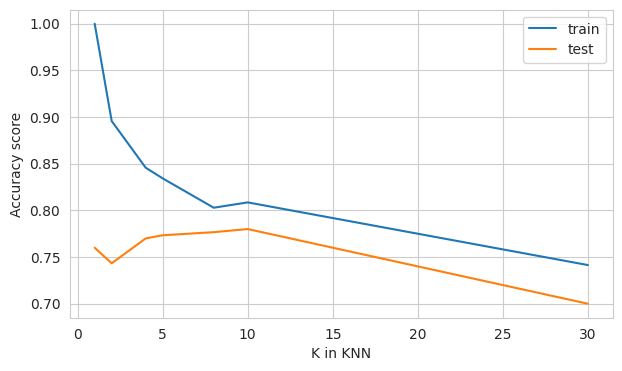

In [41]:
plt.figure(figsize=(7,4))
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("Accuracy score");

## Задание 2. KNN на датасете diabetes (10 баллов)

Теперь попробуем применить KNN к задаче регрессии. Будем работать с [данными](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) о диабете. В этом задании будем использовать класс `KNeighborsRegressor` из библиотеки `sklearn`. Загрузим необходимые библиотеки:

In [42]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [43]:
X, y = load_diabetes(as_frame=True, return_X_y=True)

In [44]:
Xn, yn = load_diabetes(as_frame=True, return_X_y=True, scaled=False) # данные без предобработки

In [45]:
X.head(3)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930


In [46]:
Xn.head(3)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,59.0,2.0,32.1,101.0,157.0,93.2,38.0,4.0,4.8598,87.0
1,48.0,1.0,21.6,87.0,183.0,103.2,70.0,3.0,3.8918,69.0
2,72.0,2.0,30.5,93.0,156.0,93.6,41.0,4.0,4.6728,85.0


### 2.1. EDA (2 обязательных балла + 2 доп. балла за Pipeline)

Сделайте EDA, предобработайте данные так, как считаете нужным, нужна ли в данном случае стандартизация и почему? Не забудте, что если вы стандартизуете данные, то нужно считать среднее и сдандартное отклонение на тренировочной части и с помощью них трансформировать и train, и test (**если не поняли это предложение, то обязательно разберитесь**).

**Дополнительно**:
Попробуйте разобраться с [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), чтобы можно было создать класс, который сразу проводит стандартизацию и обучает модель (или делает предсказание). Пайплайны очень удобны, когда нужно применять различные методы предобработки данных (в том числе и к разным столбцам), а также они позволяют правильно интегрировать предобработку данных в различные классы для поиска наилучших гиперпараметров модели (например, `GridSearchCV`).

#### 2.1.1 EDA для предобработанных данных

Видно, что все данные нормированы, пропущенных значений нет. Всего 442 наблюдения, для X и y совпадает, всё хорошо. Только категориальная переменная 'sex' переведена в численную.

In [47]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
dtypes: float64(10)
memory usage: 34.7 KB


In [48]:
X.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01


In [49]:
X.isnull().sum().sum()

0

#### 2.1.2 EDA для необработанных данных

In [50]:
Xn.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,48.518100,1.468326,26.375792,94.647014,189.140271,115.439140,49.788462,4.070249,4.641411,91.260181
std,13.109028,0.499561,4.418122,13.831283,34.608052,30.413081,12.934202,1.290450,0.522391,11.496335
min,19.000000,1.000000,18.000000,62.000000,97.000000,41.600000,22.000000,2.000000,3.258100,58.000000
25%,38.250000,1.000000,23.200000,84.000000,164.250000,96.050000,40.250000,3.000000,4.276700,83.250000
50%,50.000000,1.000000,25.700000,93.000000,186.000000,113.000000,48.000000,4.000000,4.620050,91.000000
75%,59.000000,2.000000,29.275000,105.000000,209.750000,134.500000,57.750000,5.000000,4.997200,98.000000
max,79.000000,2.000000,42.200000,133.000000,301.000000,242.400000,99.000000,9.090000,6.107000,124.000000


In [51]:
Xn.isnull().sum().sum()

0

In [52]:
Xn['sex'].value_counts()

sex
1.0    235
2.0    207
Name: count, dtype: int64

Можно порисовать картинки

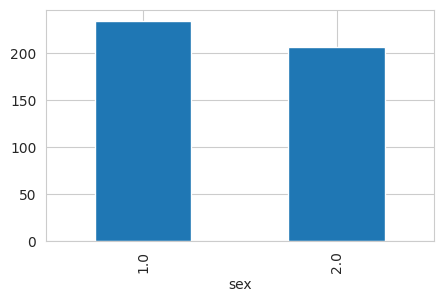

In [53]:
plt.figure(figsize=(5, 3))

Xn['sex'].value_counts().plot(kind='bar');

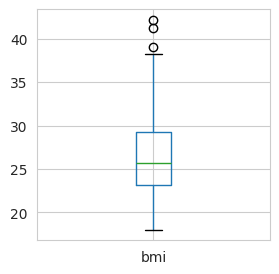

In [54]:
plt.figure(figsize=(3, 3))

Xn[['bmi']].boxplot();

#### 2.1.3 Pipline для необработанных данных

In [58]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [59]:
cat_cols = ['sex']
num_cols = ['age', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [60]:
preprocessor = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), num_cols),
    ('ohe', OneHotEncoder(drop='if_binary'), cat_cols)
])

In [61]:
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', KNeighborsRegressor(n_neighbors=8, n_jobs=8))
])

### 2.2. Регрессионная модель (1 балл)

Создайте модель `KNeighborsRegressor`, обучите ее на треноровочных данных и сделайте предсказания.

#### 2.2.1 Регрессионная модель для предобработанных данных
Нормировать не нужно.

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=SEED)

In [63]:
knn = KNeighborsRegressor(n_neighbors=8)

In [64]:
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=8)

In [65]:
prediction = knn.predict(X_test)

#### 2.2.2 Регрессионная модель для необработанных данных с Pipeline

In [66]:
Xn_train, Xn_test, yn_train, yn_test = train_test_split(Xn, 
                                                    yn, 
                                                    test_size=0.2,
                                                    random_state=SEED)

In [67]:
knn_pipeline.fit(Xn_train, yn_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['age', 'bmi', 'bp', 's1',
                                                   's2', 's3', 's4', 's5',
                                                   's6']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['sex'])])),
                ('knn', KNeighborsRegressor(n_jobs=8, n_neighbors=8))])

In [68]:
prediction_n = knn_pipeline.predict(Xn_test)

### 2.3. Метрики регресии (3 балла)

Реализуйте метрики $R^2$, MSE и  MAE в `metrics.py`. Примените их для оценки качества полученной модели. Все ли хорошо?

Напомню, что:

$R^2 = 1 - \frac{\sum_i^n{(y_i - \hat{y_i})^2}}{\sum_i^n{(y_i - \overline{y})^2}}$

$MSE = \frac{1}{n}\sum_i^n{(y_i - \hat{y_i})^2}$

$MAE = \frac{1}{n}\sum_i^n{|y_i - \hat{y_i}|}$

In [70]:
from metrics import r_squared, mse, mae

Для предобработанных

In [71]:
r_squared(prediction, y_test)

0.41584610299614544

In [72]:
mse(prediction, y_test)

2745.784234550562

In [73]:
mae(prediction, y_test)

41.936797752808985

Для необработанных

In [74]:
r_squared(prediction_n, yn_test)

0.37393440799878863

In [75]:
mse(prediction_n, yn_test)

2942.7879213483147

In [76]:
mae(prediction_n, yn_test)

43.38202247191011

### 2.4. Подбор оптимального числа соседей (2 балла)

Мы почти дошли до конца. Теперь осталось при помощи реализованных нами метрик выбрать лучшее количество соседей для нашей модели.

!!! Обратите внимание на то, что значат наши метрики, для некоторых хорошо, когда они уменьшаются, для других наоборот.

#### 2.4.1 Для предобработанных данных

In [89]:
k_neighbors = [1, 2, 3, 5, 7, 10, 30]
r_sq_scores = []
mse_scores = []
mae_scores = []

for k in k_neighbors:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    prediction = knn.predict(X_test)
    
    r_sq_value = r_squared(prediction, y_test)
    mse_value = mse(prediction, y_test)
    mae_value = mae(prediction, y_test)
    
    r_sq_scores += [r_sq_value]
    mse_scores += [mse_value]
    mae_scores += [mae_value]
    
    print(k, f'{r_sq_value:.3g}, {mse_value:.3g}, {mae_value:.3g}')

1 -0.00116, 4.71e+03, 52.6
2 0.253, 3.51e+03, 45.5
3 0.237, 3.59e+03, 45.7
5 0.352, 3.05e+03, 41.1
7 0.387, 2.88e+03, 42.6
10 0.444, 2.62e+03, 41.1
30 0.425, 2.7e+03, 41.5


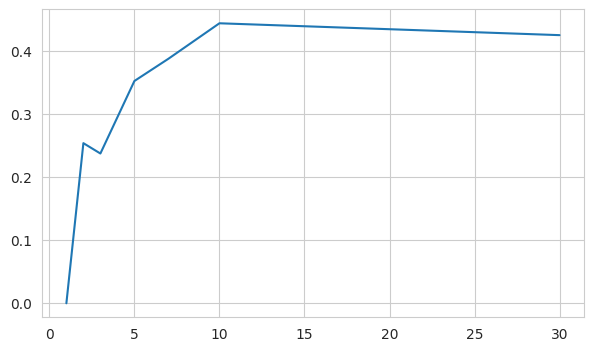

In [90]:
plt.figure(figsize=(7,4))
sns.lineplot(x=k_neighbors, y=r_sq_scores);

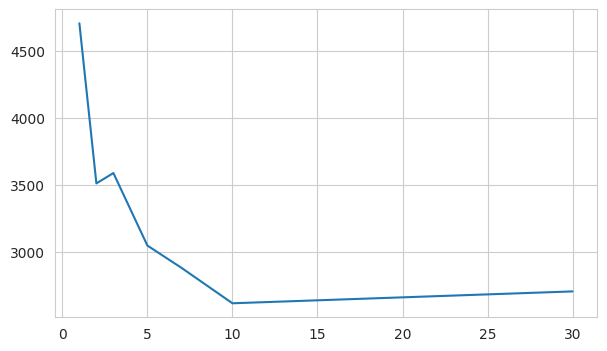

In [91]:
plt.figure(figsize=(7,4))
sns.lineplot(x=k_neighbors, y=mse_scores);

#### 2.4.2 Для необработанных данных с Pipeline

In [85]:
preprocessor = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), num_cols),
    ('ohe', OneHotEncoder(drop='if_binary'), cat_cols)
])

In [92]:
k_neighbors = [1, 2, 3, 5, 7, 10, 30]
r_sq_scores = []
mse_scores = []
mae_scores = []

for k in k_neighbors:
    knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', KNeighborsRegressor(n_neighbors=k, n_jobs=8))
    ])
    knn_pipeline.fit(Xn_train, yn_train)
    prediction_n = knn_pipeline.predict(Xn_test)
    
    r_sq_value = r_squared(prediction_n, yn_test)
    mse_value = mse(prediction_n, yn_test)
    mae_value = mae(prediction_n, yn_test)
    
    r_sq_scores += [r_sq_value]
    mse_scores += [mse_value]
    mae_scores += [mae_value]
    
    print(k, f'{r_sq_value:.3g}, {mse_value:.3g}, {mae_value}')

1 -0.103, 5.18e+03, 56.04494382022472
2 0.198, 3.77e+03, 46.848314606741575
3 0.285, 3.36e+03, 46.55805243445693
5 0.299, 3.3e+03, 45.00449438202247
7 0.384, 2.9e+03, 42.7817014446228
10 0.412, 2.76e+03, 41.715730337078654
30 0.427, 2.69e+03, 41.64194756554308


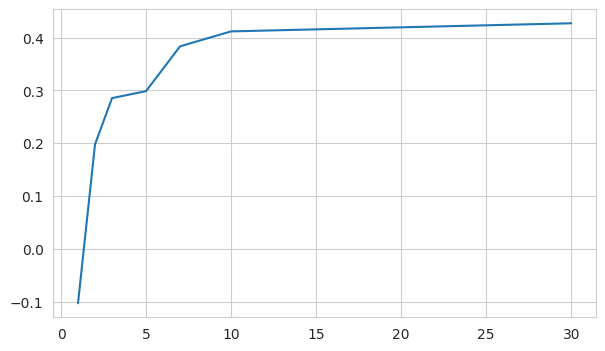

In [93]:
plt.figure(figsize=(7,4))
sns.lineplot(x=k_neighbors, y=r_sq_scores);

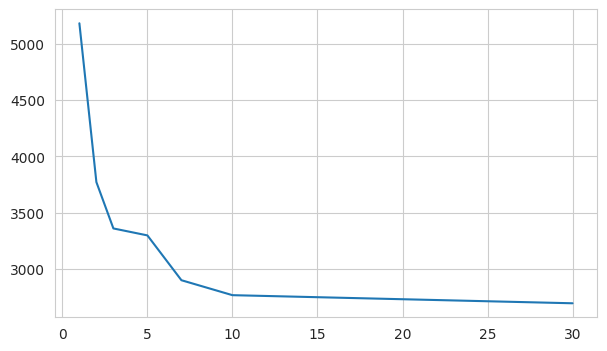

In [94]:
plt.figure(figsize=(7,4))
sns.lineplot(x=k_neighbors, y=mse_scores);

Для поиска лучшего k вы можете воспользоваться функцией `find_best_k`, которую вы реализовали выше.

### 3. Социализация (0.5 доп. балла)

Так как у нас теперь большая группа, то было бы здорово всем познакомиться получше (так как выпускной не за горами). Соберитесь с одногруппниками в зуме, познакомьтесь, а сюда прикрепите скриншот с камерами всех участников.

<img src="meet.png" alt="Great meet" width="900"/>

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**

Противоречивые чувства.
Очень интересное задание. Достаточно подробное, хорошо составленное и оформленное, разнообразное. Здорово, что нужно "заглядывать под капот", писать свои реализации каких-то базовых функций.
Но делать его было очень сложно. Очень большой объём. Много времени ушло, чтобы вспомнить даже уже пройденный материал, по numpy, в основном. Долго приходилось искать какие-то элементарные вещи (правильный броадкастинг, подобрать параметры axis м т.д.). С непривычки сильно путаешься в опредениях, трейн, тест. Из-за этого много времени уходило исправление совсем базовых ошибок, а возможности разобрать, что получилось, вдуматься в более серьёзные части задания уже попросту не оставалось. Самое обидное имеено то, что даже сделанные вещи до конца не понимаешь, некоторые подбирая чуть ли не наугад. Попробовал - сработало, кажется, и оставляешь так. При этом не могу сказать, что непонятно было, что делать. Просто времени не хватает, лично для моего ритма работы и скорости соображения.